In [2]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [3]:
BASE_DIR = '/content/drive/MyDrive/mle_task/input/dataset'
WORKING_DIR = '/content/drive/MyDrive/mle_task/working'

In [4]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

553467096/553467096 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [5]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/4516 [00:00<?, ?it/s]

In [6]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [7]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [8]:
import pandas as pd

# Load the captions data from CSV file
descriptions_df = pd.read_csv(os.path.join(BASE_DIR, 'descriptions.csv'))
# Create mapping of image to captions
mapping = {}
for i in range(len(descriptions_df)):
    caption, image_id = descriptions_df.iloc[i, 0], descriptions_df.iloc[i, 1]
    image_id = image_id.split('.')[0]  # remove extension from image ID
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

In [9]:
len(mapping)

4516

In [10]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [13]:
# preprocess the text
clean(mapping)

In [14]:
# after preprocess of text
mapping['48d27a28-851f-4fcb-82b1-b252ea5d8295']

['startseq one triangle that is identical to the original has been drawn and shaded below the original triangle. they are aligned at the bases and meet to form parallelogram. endseq']

In [16]:
len(all_captions)

4516

In [17]:
all_captions[:10]

['startseq one triangle that is identical to the original has been drawn and shaded below the original triangle. they are aligned at the bases and meet to form parallelogram. endseq',
 'startseq one triangle drawn above the original triangle and connected on the long side to make parallelogram endseq',
 'startseq ”x2” written next to the original triangle. arrow pointing right. rectangle with line from the top left to bottom right corner. endseq',
 'startseq student drew and shaded an identical triangle above the original and aligned with the long side to make parallelogram. there are parentheses with hearts in them above and below the shape and parentheses with stars in them on the left and right sides. there is an arrow pointing from the explanation to the model. endseq',
 'startseq shaded triangle drawn above the original triangle aligned with the long side to create parallelogram. endseq',
 'startseq the student filled in "25" in the top number line. the student completed the botto

In [18]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
pickle.dump(tokenizer, open(os.path.join(WORKING_DIR, 'tokenizer.pkl'), 'wb'))

In [19]:
vocab_size

2049

In [21]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

213

In [22]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [24]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

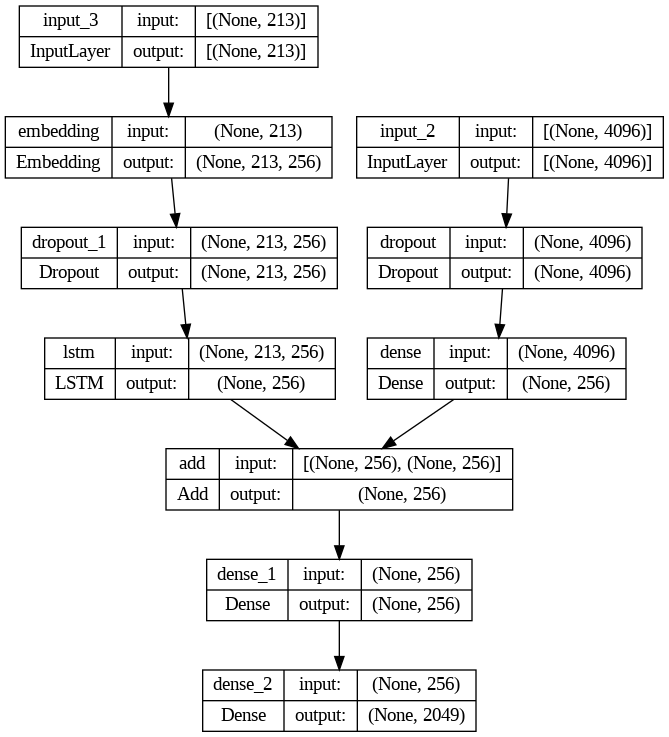

In [25]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [26]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

127/127 [==============================] - 86s 680ms/step - loss: 1.5775


In [27]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [29]:
# generate description for student image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

In [30]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/452 [00:00<?, ?it/s]

BLEU-1: 0.150586
BLEU-2: 0.073447


In [31]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "48d27a28-851f-4fcb-82b1-b252ea5d8295.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq one triangle that is identical to the original has been drawn and shaded below the original triangle. they are aligned at the bases and meet to form parallelogram. endseq
--------------------Predicted--------------------
startseq rectangle composed of two small right triangles with one half written inside of each two medium right triangles with one half written inside it endseq


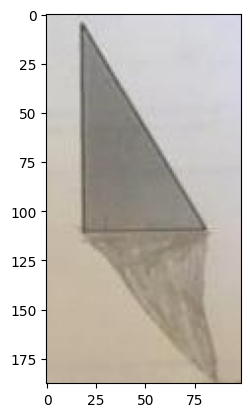

In [32]:
generate_caption("48d27a28-851f-4fcb-82b1-b252ea5d8295.jpg")

---------------------Actual---------------------
startseq one triangle drawn above the original triangle and connected on the long side to make parallelogram endseq
--------------------Predicted--------------------
startseq rectangle composed of two small right triangles with frac 1 2 written next to it endseq


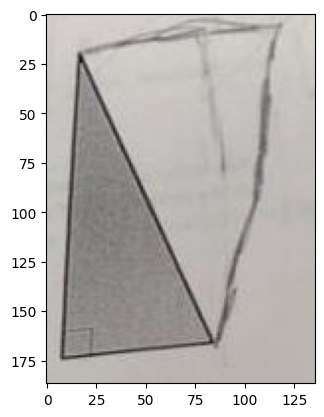

In [39]:
generate_caption("420ec849-d0da-4f45-aed0-645bfa3b1d62.jpg")

---------------------Actual---------------------
startseq ”x2” written next to the original triangle. arrow pointing right. rectangle with line from the top left to bottom right corner. endseq
--------------------Predicted--------------------
startseq rectangle with length of and width of 12 and width of centimeter endseq


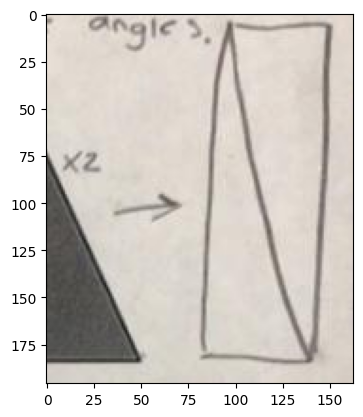

In [34]:
generate_caption("c5cc8cbc-7844-405b-a204-6aca67ef4384.jpg")

---------------------Actual---------------------
startseq two column table endseq
--------------------Predicted--------------------
startseq drew three groups of each group named group named group named group of maple syrup with six squares labeled ms endseq


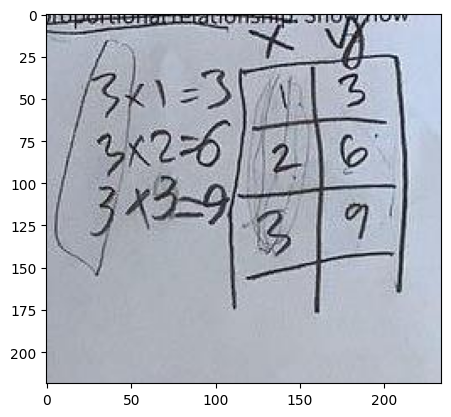

In [35]:
generate_caption("45a99e10-f73a-4c33-bfb8-e6d2e5574367.jpg")